In [1]:
# https://www.tensorflow.org/install/source#gpu
! nvcc  --version

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import math
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from src.utils import apply_circular_mask, cartesian_to_polar_grid, polar_transform, polar_transform_inv
from src.model import toeplitz_extractor
from src.visu import add_grad_coloring

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


/var/tmp/ipykernel_425682/3154163727.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-15 11:47:21.008675: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 11:47:21.008773: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 11:47:21.008798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518

Num GPUs Available:  1


2024-02-15 11:47:25.224789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43606 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:03:00.0, compute capability: 8.6


In [2]:
import wandb
from datetime import datetime

dataset_name = 'fashion_mnist' # fashion_mnist
image_size = 28
batch_size = 1024
n_epochs = 10
n_classes = 10

# see polar_transform
radius = (np.array([image_size, image_size])**2).sum()**0.5/2
len_beam = int(round(radius))
n_beams = int(round(radius*2*np.pi))
print(len_beam, n_beams)

config = {
}

wandb.init(project="RadialBeams", config=config, group='f-mnist', name=datetime.now().strftime("%m%d-%H%M"))

20 124


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johschm. Use `wandb login --relogin` to force relogin


In [3]:
plt.rcParams["image.cmap"] = "gray"

train_dataset = tfds.load(dataset_name, split='train', shuffle_files=False)
test_dataset = tfds.load(dataset_name, split='test', shuffle_files=False)

def preprocess(example):
    image = tf.cast(example['image'], tf.float32) / 255.
    return {
        'image': image,
        'label': example['label'],
        'polar': polar_transform(image)
    }

train_dataset = train_dataset.map(preprocess).shuffle(buffer_size=10000).batch(batch_size)
test_dataset = test_dataset.map(preprocess).batch(batch_size)

2024-02-15 11:47:29.983363: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


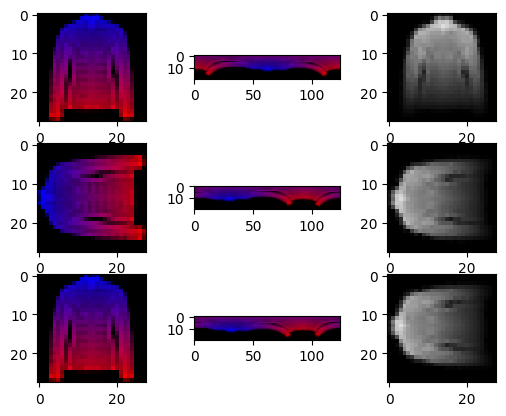

In [4]:
%matplotlib inline
fig, axs = plt.subplots(3,3)

data = next(iter(test_dataset))
image = data['image'][1]
image = add_grad_coloring(image)

rot_image = tfa.image.rotate(image, np.pi/2, interpolation='bilinear')
rot_image = tf.cast(rot_image, tf.float32)

axs[0, 0].imshow(image)
axs[1, 0].imshow(rot_image)
axs[2, 0].imshow(image)

polar = polar_transform(image)
rot_polar = polar_transform(rot_image)
shifted_polar = tf.roll(polar, shift=-n_beams//4, axis=1)

axs[0, 1].imshow(polar)
axs[1, 1].imshow(rot_polar)
axs[2, 1].imshow(shifted_polar)

polar_inv = polar_transform_inv(polar.numpy(), output=(image_size, image_size))
rot_polar_inv = polar_transform_inv(rot_polar.numpy(), output=(image_size, image_size))
shifted_polar_inv = polar_transform_inv(shifted_polar.numpy(), output=(image_size, image_size))

axs[0, 2].imshow(polar_inv)
axs[1, 2].imshow(rot_polar_inv)
axs[2, 2].imshow(shifted_polar_inv)

plt.show()

In [5]:
from tensorflow.keras import layers, models

def cyclic_beam_padding(x, padding=1):
    return tf.concat([x[:, :, x.shape[2]-padding:], x, x[:, :, :padding]], axis=-2)
    
class PolarRegressor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # padding such that kernels of size 3 on the edges use cyclic padded values
        # padding = kernel_size - 1 using "same" padding
        self.padding = 16
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(len_beam, n_beams+2*self.padding, 1)),
            # WARNING "same" padding as otherwise information along the beams would be dropped
            # layers.Conv2D(16, (3, 1), activation='gelu', padding='same'),
            layers.Conv2D(16, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(32, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),
            
            # layers.Conv2D(32, (3, 1), activation='gelu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),
            # WARNING max pooling along beams removes spatial information, which is important, though
            # layers.MaxPooling2D((2, 1)),
            
            # layers.Conv2D(64, (3, 1), activation='gelu', padding='same'),
            layers.Conv2D(32, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(16, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),
            # layers.MaxPooling2D((2, 1)),
        ])
        self.encoder2 = models.Sequential([
            layers.InputLayer(input_shape=(n_beams, 320)),
            layers.Dense(64, activation='gelu'),
            layers.Dense(1),
            layers.Flatten()
        ])
    
    def call(self, x):
        if self.padding > 0:
            x = cyclic_beam_padding(x, padding=self.padding)
        z = self.encoder(x)
        z = tf.transpose(z, (0, 2, 1, 3))
        z = tf.reshape(z, (z.shape[0], z.shape[1], -1))
        if self.padding > 0:
            z = z[:, self.padding//2:n_beams+self.padding//2]
        z = self.encoder2(z)
        # z = tf.nn.softmax(z, axis=-1)
        return z / tf.norm(z, axis=-1, keepdims=True)

model = PolarRegressor()
model.build(input_shape=(batch_size, len_beam, n_beams, 1))
model.summary()
model(tf.zeros((batch_size, len_beam, n_beams, 1))).shape

Model: "polar_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 20, 156, 16)       83536     
                                                                 
 sequential_1 (Sequential)   (None, 124)               20609     
                                                                 
Total params: 104145 (406.82 KB)
Trainable params: 104145 (406.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-02-15 11:47:33.166856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


TensorShape([1024, 124])

In [6]:
def roll_batch(tensor, roll_values, axis=2):
  return tf.stack([tf.roll(tensor[i], roll_values[i], axis=axis-1) for i in range(tensor.shape[0])])

true = np.zeros((n_beams, image.shape[0]))
true[n_beams//2] = 1
true = tf.convert_to_tensor(true, dtype=tf.float32)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
for e in  tqdm(range(n_epochs)):
    # training loop
    for s, sample in enumerate(train_dataset):
        image, label = sample['polar'], sample['label']
        with tf.GradientTape() as tape:
            k_distribution = model(image)
            # cosine of hyper-unit-vectors -> normalization not needed 
            loss = 1. - (k_distribution @ true) 
            grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        wandb.log({"training loss": np.mean(loss.numpy())}, step=e*len(train_dataset)+s)
        # equivariance test loop
        image = tf.roll(image, shift=20, axis=2) # see example above shift to right
        k_true = tf.cast(tf.fill((image.shape[0], ), 20), tf.int64) + n_beams//2
        test_loss = tf.abs(k_true - tf.argmax(model(image), axis=-1))
        wandb.log({"equivariance test": np.mean(test_loss.numpy())}, step=e*len(train_dataset)+s)
    # pseudo-equivariant test loop
    test_loss = []
    for s, sample in enumerate(test_dataset):
        image, label = sample['polar'], sample['label']
        k = tf.random.uniform(shape=(image.shape[0],), minval=-n_beams//2, maxval=n_beams//2, dtype=tf.int64)
        image = roll_batch(image, k, axis=2)
        k_distribution = model(image)
        test_loss.append(tf.abs(k + n_beams//2 - tf.argmax(k_distribution, axis=-1)).numpy())
    wandb.log({"testing loss": np.concatenate(test_loss, axis=0).mean()})
    print(np.concatenate(test_loss, axis=0).mean())
# todo implement load and save of models 

  0%|                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]2024-02-15 11:47:49.481033: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xe99e6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 11:47:49.481090: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-02-15 11:47:49.484629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 11:47:49.592967: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 10%|████████████████▊                                                                                                                                                       | 1/10 [01:21<12:16, 81.86s/it]

15.8413


 20%|█████████████████████████████████▌                                                                                                                                      | 2/10 [02:20<09:05, 68.14s/it]

12.1716


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 3/10 [03:18<07:24, 63.55s/it]

5.7904


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 4/10 [04:16<06:08, 61.45s/it]

3.2511


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 5/10 [05:15<05:02, 60.58s/it]

2.1228


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 6/10 [06:14<03:59, 59.84s/it]

1.1532


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7/10 [07:12<02:58, 59.42s/it]

1.042


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 8/10 [08:10<01:58, 59.05s/it]

0.7662


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9/10 [09:08<00:58, 58.68s/it]

0.8136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:07<00:00, 60.70s/it]

0.5154


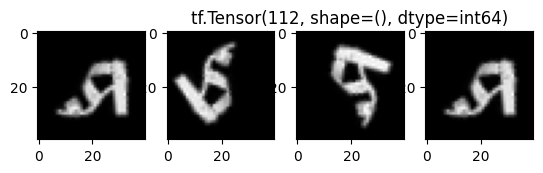

In [8]:
fig, axs = plt.subplots(1,4)
for s, sample in enumerate(train_dataset):
    image, label = sample['polar'], sample['label']
    axs[0].imshow(polar_transform_inv(image[0].numpy()))
    image = tf.roll(image, shift=50, axis=2)
    axs[1].imshow(polar_transform_inv(image[0].numpy()))
    k_distribution = model(image)
    k = tf.argmax(k_distribution, axis=-1)
    image_undo = tf.roll(image[0], shift=n_beams//2+k[0], axis=1)
    axs[2].imshow(polar_transform_inv(image_undo.numpy()))
    axs[2].set_title(k[0])
    image_undo = tf.roll(image[0], shift=n_beams//2-k[0], axis=1)
    axs[3].imshow(polar_transform_inv(image_undo.numpy()))
    plt.show()
    break